# Music instrument recognition using deep convolutional neural networks

In [1]:
import librosa

import matplotlib.pyplot as plt
import librosa.display
import numpy as np

import pandas as pd

import os

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

### Visualizing Audio Signal

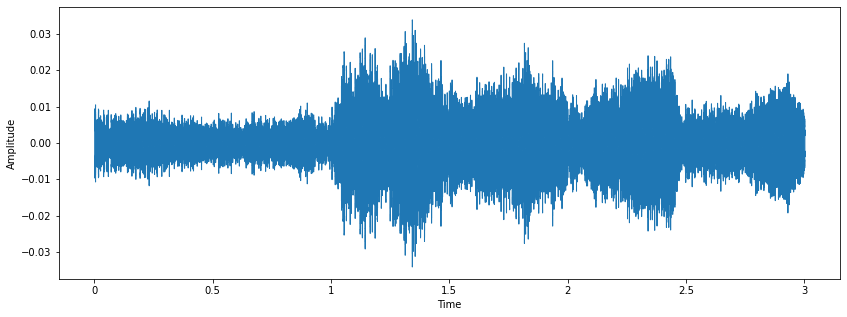

In [2]:
sample_audio, sample_sr = librosa.load('AudioFiles/TrainingData/cel/008__[cel][nod][cla]0058__1.wav', sr = None)

plt.figure(figsize=(14, 5))
plt.ylabel("Amplitude")
librosa.display.waveshow(sample_audio, sr = sample_sr)

### Visualizing Audio Signal Spectrogram

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

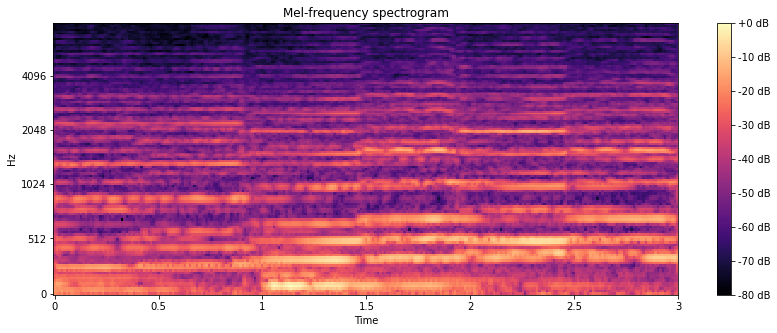

In [3]:
plt.rcParams["figure.figsize"] = [14, 5]

fig, ax = plt.subplots()

S = librosa.feature.melspectrogram(y = sample_audio, sr = sample_sr, n_mels = 128, fmax = 8000)

S_dB = librosa.power_to_db(S, ref = np.max)

img = librosa.display.specshow(S_dB, x_axis = 'time', y_axis = 'mel', sr = sample_sr, fmax = 8000)

fig.colorbar(img, ax = ax, format = '%+2.0f dB')

ax.set(title = 'Mel-frequency spectrogram')

### Creating a dataframe with audio files path and their classes

In [4]:
root = 'AudioFiles\TrainingData'

dataset = pd.DataFrame(columns = ['file_path', 'audio_class'])

i = 0

for path, currentDirectory, files in os.walk(root):

    splitted_path = path.split("\\")

    if len(splitted_path) == 3:
        class_sub_directory = splitted_path[2]

        for file in files:
            data = {'file_path' : os.path.join(path, file), 'audio_class' : class_sub_directory}

            dataset.loc[i] = data

            i += 1


dataset.head()

,file_path,audio_class
0,AudioFiles\TrainingData\cel\008__[cel][nod][cl...,cel
1,AudioFiles\TrainingData\cel\008__[cel][nod][cl...,cel
2,AudioFiles\TrainingData\cel\008__[cel][nod][cl...,cel
3,AudioFiles\TrainingData\cel\012__[cel][nod][cl...,cel
4,AudioFiles\TrainingData\cel\012__[cel][nod][cl...,cel


### Getting number of audio files and Class Distributions

In [5]:
print("Number of audio files :", len(dataset))

dataset["audio_class"].value_counts()

Number of audio files : 6705


voi    778
gel    760
pia    721
org    682
gac    637
sax    626
vio    580
tru    577
cla    505
flu    451
cel    388
Name: audio_class, dtype: int64

### Extracting Features

A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale. The mel scale is a scale of pitches judged by listeners to be equal in distance one from another. The reference point between this scale and normal frequency measurement is defined by equating a 1000 Hz tone, 40 dB above the listener's threshold, with a pitch of 1000 mels.

In [6]:
def features_extractor(file_path):
    audio, sample_rate = librosa.load(file_path)

    melSpec = librosa.feature.melspectrogram(y = audio, sr = sample_rate, fmax = 8000)

    return melSpec

In [7]:
extracted_features = []

for index, row in tqdm(dataset.iterrows()):
    file_path = row["file_path"]

    audio_class = row['audio_class']

    features = features_extractor(file_path)

    extracted_features.append([features, audio_class])

6705it [12:55,  8.64it/s]


### Converting extracted features list to dataframe

In [8]:
extracted_features_df = pd.DataFrame(extracted_features, columns = ['feature', 'class'])

extracted_features_df.head()


,feature,class
0,"[[0.024605189, 0.026414914, 0.019840304, 0.018...",cel
1,"[[0.003204681, 0.006362769, 0.008847577, 0.011...",cel
2,"[[0.014211558, 0.013765885, 0.015926616, 0.028...",cel
3,"[[0.20625964, 1.0901259, 1.3749367, 0.6423693,...",cel
4,"[[0.008237363, 0.055804554, 0.0881767, 0.07231...",cel


### Splitting data into Dependant and Independent


In [9]:
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

### One-Hot Encoding Class Labels

In [10]:
y = np.array(pd.get_dummies(y))

### Training - Validation - Testing Split


In [11]:
# Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

# Validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size = 0.75, random_state = 0)

### Reshaping Data

In [12]:
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

### Training, Validation, and Testing sizes


In [13]:
print("Training shape :", X_train.shape, y_train.shape)
print("Validation shape :", X_validation.shape, y_validation.shape)
print("Testing shape :", X_test.shape, y_test.shape)

Training shape : (4023, 128, 130, 1) (4023, 11)
Validation shape : (1341, 128, 130, 1) (1341, 11)
Testing shape : (1341, 128, 130, 1) (1341, 11)


### Creating CNN Model with initial num filter of 32 to 512

In [14]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
number_of_classes = y.shape[1]

model = tf.keras.Sequential()

initial_filters = 32

# Adding Convolution layers
while initial_filters != 512:
    model.add(tf.keras.layers.Conv2D(filters = initial_filters, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape, padding = 'same'))

    model.add(tf.keras.layers.MaxPool2D(pool_size = (3, 3)))

    # model.add(tf.keras.layers.Dropout(rate = 0.25))

    initial_filters *= 2

# Adding Flatten Layer
model.add(tf.keras.layers.Flatten())

# Adding Fully Connected Layer (Dense Layer)
model.add(tf.keras.layers.Dense(64, activation = 'relu'))

# Adding a Dropout layer to avoid over-fitting
model.add(tf.keras.layers.Dropout(rate = 0.5))

# Output layer with softmax activation
model.add(tf.keras.layers.Dense(number_of_classes, activation = 'softmax'))

### Viewing Model Summary

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 130, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 43, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

### Compiling the model


In [16]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Training the Model

In [17]:
number_of_epochs = 60

checkpoint = ModelCheckpoint(filepath = 'SavedModels/model.hdf5', verbose = 1, save_best_only = True)

start = datetime.now()

model.fit(X_train, y_train, epochs = number_of_epochs, validation_data = (X_validation, y_validation), callbacks = [checkpoint])

duration = datetime.now() - start
print("Training completed in :", duration)

Epoch 1/60
126/126 [==============================] - ETA: 0s - loss: 2.5210 - accuracy: 0.1084
Epoch 1: val_loss improved from inf to 2.39293, saving model to SavedModels\model.hdf5
126/126 [==============================] - 25s 192ms/step - loss: 2.5210 - accuracy: 0.1084 - val_loss: 2.3929 - val_accuracy: 0.1163
Epoch 2/60
126/126 [==============================] - ETA: 0s - loss: 2.3888 - accuracy: 0.1178
Epoch 2: val_loss improved from 2.39293 to 2.38938, saving model to SavedModels\model.hdf5
126/126 [==============================] - 23s 185ms/step - loss: 2.3888 - accuracy: 0.1178 - val_loss: 2.3894 - val_accuracy: 0.1163
Epoch 3/60
126/126 [==============================] - ETA: 0s - loss: 2.3848 - accuracy: 0.1178
Epoch 3: val_loss improved from 2.38938 to 2.38730, saving model to SavedModels\model.hdf5
126/126 [==============================] - 23s 185ms/step - loss: 2.3848 - accuracy: 0.1178 - val_loss: 2.3873 - val_accuracy: 0.1163
Epoch 4/60
126/126 [=====================

KeyboardInterrupt: 